# Ciphix Machine Learning Case
Auteur: Sander Boers


Dit is een opdracht dat onderdeel is van de sollicatie procedure voor Ciphix. Het doel is om uit groot tekstbestand machine-learning technieken toe te passen, om 'topics' te bepalen typerend voor een gesprek.

In [43]:
import pandas as pd

data = pd.read_csv('data.csv', names=['text']) #.head(n=120000) # optional: to shrink the dataset

ONLY_CUSTOMERS = True
if ONLY_CUSTOMERS:
    filter = data['text'].str.contains(r'@([0-9]+)')
    data = data[~filter]

C:\Users\boers\AppData\Local\Temp\ipykernel_2288\2098558752.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filter = data['text'].str.contains(r'@([0-9]+)')


In [44]:
import re
import spacy
import gensim

nlp = spacy.load("en_core_web_sm", disable = ["parser", "ner"])
allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]

def preprocess(doc):
  # Regex to remove URLs
  doc = re.sub(r'\bhttps?://\S+\b', '', doc) 

  # Regex to remove mentions, e.g. @UberSupport
  # doc = re.sub(r'@\w+\b', '', doc) 

  # Regex to remove signatures starting with ('^', '-' or '*')
  doc = re.sub(r'\B[-^*&]\s*\w+', '', doc) 
  
  # Regex to remove any symbols, emojis or non-western charachters
  doc = re.sub(r'[^a-zA-Z0-9\s,.?!;:()]+', '', doc) 
  
  # Function to convert document into lowercase, de-accents and tokenize
  doc = gensim.utils.simple_preprocess(doc, deacc=True, min_len=2)

  return doc
  

data['preprocessed_text'] = data['text'].apply(preprocess)

In [45]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data['preprocessed_text'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data['preprocessed_text']], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


stopwords = nlp.Defaults.stop_words
stopwords.update(["hi", "hello", "hey", "et"])

def apply_trigrams(doc):
  doc = [token for token in doc if token not in stopwords]
  doc = trigram_mod[bigram_mod[doc]]
  return doc

data['trigram_text'] = data['preprocessed_text'].apply(apply_trigrams)
data = data[data['trigram_text'].apply(len) > 2]


In [46]:
def apply_lemmatization(doc):
  doc = nlp(" ".join(doc))
  doc = [token.lemma_ for token in doc if token.pos_ in allowed_postags and len(token) > 2]
  return doc

data['lemmatization_text'] = data['trigram_text'].apply(apply_lemmatization)

In [47]:
from gensim.corpora import Dictionary

dictionary = Dictionary(data['lemmatization_text'])
corpus = [dictionary.doc2bow(doc) for doc in data['lemmatization_text']]

In [48]:
from gensim.models import LdaModel

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)

In [49]:
for topic_id in range(10):
    print(f'Topic {topic_id}: {lda_model.print_topic(topic_id)}')

Topic 0: 0.027*"month" + 0.026*"issue" + 0.025*"internet" + 0.022*"comcastcare" + 0.021*"work" + 0.016*"pay" + 0.014*"time" + 0.013*"idea" + 0.013*"ideacare" + 0.013*"talk"
Topic 1: 0.043*"southwestair" + 0.038*"good" + 0.032*"thank" + 0.032*"chipotletweet" + 0.022*"year" + 0.016*"get" + 0.016*"great" + 0.015*"love" + 0.010*"food" + 0.009*"delta"
Topic 2: 0.096*"service" + 0.071*"customer" + 0.030*"upshelp" + 0.022*"call" + 0.020*"bad" + 0.016*"phone" + 0.015*"help" + 0.015*"answer" + 0.014*"day" + 0.014*"care"
Topic 3: 0.053*"help" + 0.037*"email" + 0.036*"need" + 0.035*"account" + 0.034*"number" + 0.025*"check" + 0.025*"book" + 0.023*"charge" + 0.023*"driver" + 0.021*"contact"
Topic 4: 0.045*"day" + 0.031*"train" + 0.027*"week" + 0.026*"time" + 0.023*"virgintrain" + 0.019*"today" + 0.018*"gwrhelp" + 0.018*"swhelp" + 0.017*"late" + 0.016*"go"
Topic 5: 0.083*"flight" + 0.051*"americanair" + 0.033*"britishairway" + 0.026*"ticket" + 0.021*"seat" + 0.020*"hour" + 0.018*"delay" + 0.016*"fl

In [50]:
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Visualize with pyLDAvis: See [2] for more details
pyLDAvis.enable_notebook()
visualization = pyLDAvis.gensim_models.prepare(
    lda_model, 
    corpus,
    dictionary, 
    mds = "mmds", 
    R = 30)

visualization

C:\Users\boers\OneDrive\Documenten\Ciphix\venv\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\boers\OneDrive\Documenten\Ciphix\venv\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.257352  0.182999       1        1  13.963390
4      0.108106  0.405929       2        1  10.953561
5     -0.387052  0.013378       3        1  10.632196
7     -0.293705  0.337918       4        1  10.349585
3     -0.074380 -0.405120       5        1  10.228326
1     -0.114286  0.189811       6        1  10.112349
0      0.081517 -0.097649       7        1   9.574671
2     -0.329285 -0.274138       8        1   8.753899
8      0.286549 -0.369800       9        1   7.739908
6      0.465184  0.016671      10        1   7.692114, topic_info=         Term          Freq         Total Category  logprob  loglift
55      thank  86068.000000  86068.000000  Default  30.0000  30.0000
8     service  54815.000000  54815.000000  Default  29.0000  29.0000
349    flight  57671.000000  57671.000000  Default  28.0000  28.0000
7    customer  40401.000000  40401.000000  Default  27.0000  27.0000
3        send  37383.000000  37383.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
510      half   3542.878568   5110.670538  Topic10  -4.9556   2.1986
282   explain   3397.373428   4853.922196  Topic10  -4.9976   2.2082
175      hour   5292.826989  30051.401673  Topic10  -4.5542   0.8284
12         go   5168.543822  46752.290165  Topic10  -4.5780   0.3627
32        way   3748.185149  19888.464759  Topic10  -4.8993   0.8961

[505 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1078      8  0.999815  absolutely
1700      8  0.999536      accept
1058      1  0.999832      access
24        1  0.309266     account
24        5  0.690701     account
...     ...       ...         ...
1208      3  0.999611       write
151       6  0.999963        year
481       1  0.119010   yesterday
481       2  0.255229   yesterday
481       4  0.625699   yesterday

[632 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 5, 6, 8, 4, 2, 1, 3, 9, 7])

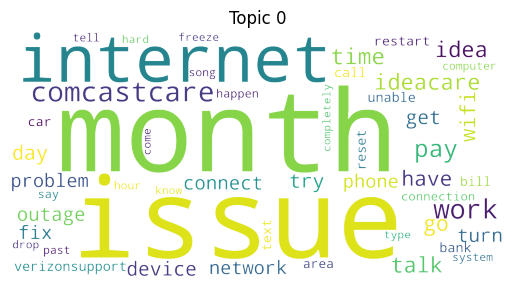

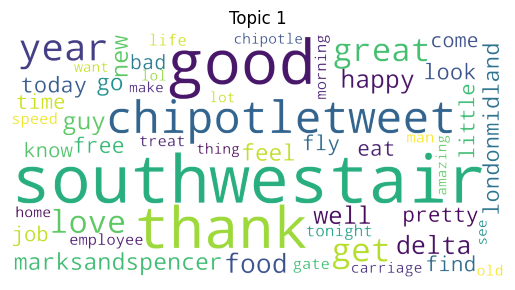

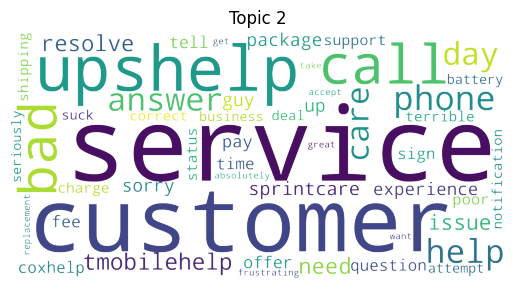

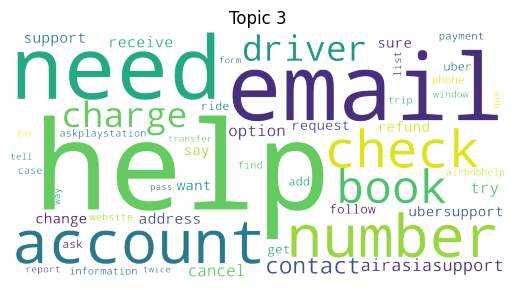

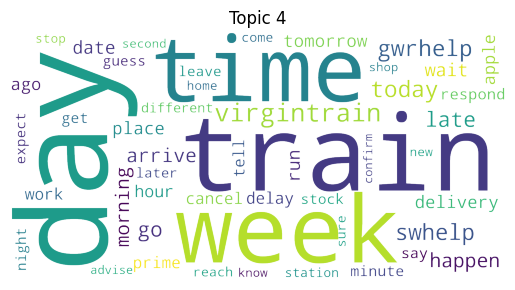

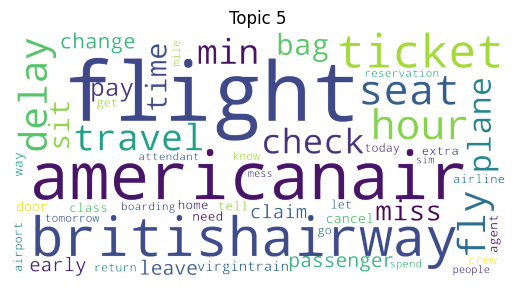

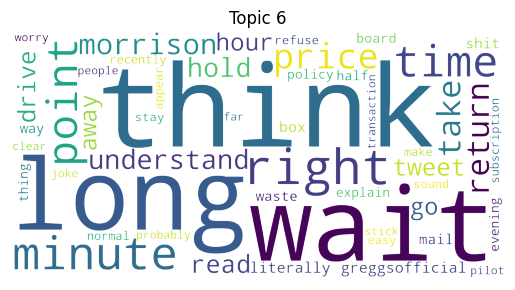

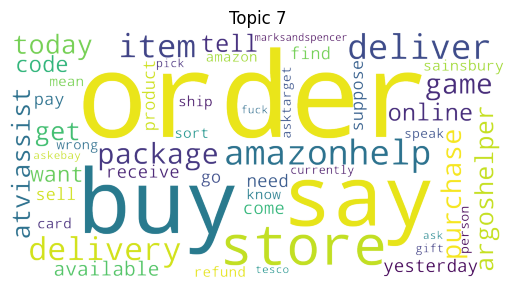

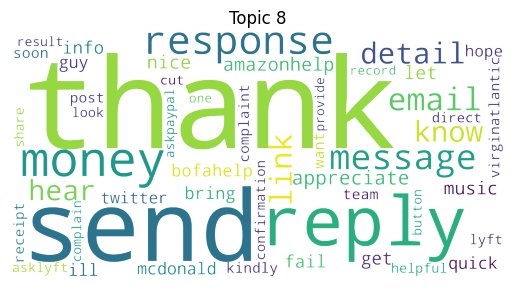

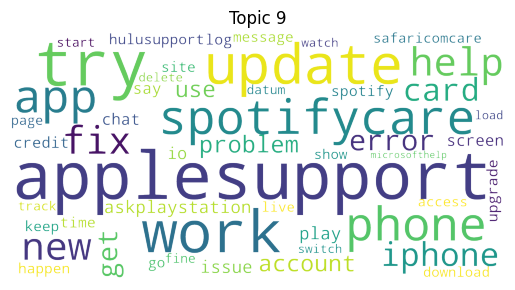

In [65]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud

for t in range(lda_model.num_topics):
    plt.figure()
    plt.gca().set_title('Topic ' + str(t))
    plt.imshow(WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", width=1600, height=800).fit_words(dict(lda_model.show_topic(t, 50))))
    plt.axis("off")
    plt.gcf().savefig(f"./static/wordclouds/topic{t}.png", transparent=True, dpi=300)
    plt.show()


In [1]:
# Save models

lda_model.save('./saved_models/LDAmodel')
bigram_mod.save("./saved_models/bigram_mod.pkl")
trigram_mod.save("./saved_models/trigram_mod.pkl")


NameError: name 'lda_model' is not defined